# Remi Arsac - Projet final du Kit Data Science 2021

In [1]:
import numpy as np
import pandas as pd
import random
import requests
import datetime as datetime
import xlrd
from bs4 import BeautifulSoup
import re
from os import listdir
import matplotlib.pyplot as plt
import seaborn as sns
from branca.element import Figure
#import folium
from sklearn.linear_model import LinearRegression
import math as m

# options d'affichage
pd.set_option("display.min_rows", 10)

# **1. Acquisition et nettoyage des données des caractéristiques techniques de chacun des voiliers**

In [2]:
# Fonction mutualisée de suppression des unités et de passage en valeurs numériques (utilisée pour plusieurs colonnes par la suite)
def convert_col_to_numeric(serie):
    serie = pd.to_numeric(serie.str.replace('°','',regex=False).str.replace('m2','',regex=False).str.replace('²','',regex=False).str.replace('[a-zA-Z]','',regex=True).str.replace(',','.',regex=False))
    return serie

# Fonction de modification du format de date de lancement pour permettre le passage en datetime
def convert_date_lancement(date):
    months = ['janvier', 'février', 'mars', 'avril', 'mai', 'juin', 'juillet', 'août',
             'septembre', 'octobre', 'novembre', 'décembre']
    num_mois = months.index(date.split(" ")[1].lower()) + 1
    if num_mois<10:   
        return date.split(" ")[0]+'/0'+str(num_mois)+'/'+date.split(" ")[2]
    else:
        return date.split(" ")[0]+'/'+str(num_mois)+'/'+date.split(" ")[2]

# Fonction de standardisation de la colonne 'No de voile'
def rename_No_de_voile(x):
    match_list = re.findall('([A-Z]*)\W*([0-9]+)', x)
    country_code = match_list[0][0]
    num_voile = match_list[0][1]
    while num_voile[0]=='0':
        num_voile = num_voile[1:]
    if len(num_voile) == 1:
        num_voile = '0' + num_voile
    if len(country_code)!=3:
        country_code = 'FRA'
    return (country_code+' '+num_voile)

In [3]:
# Récupération des caractéristiques des voiliers par web scrapping
soup = BeautifulSoup(requests.get('https://www.vendeeglobe.org/fr/glossaire').content) 
boats_list = soup.findAll('div', attrs={'class': 'boats-list__popup mfp-hide'})
param = ['Numéro de voile', 'Anciens noms du bateau', 'Architecte', 'Chantier', 
         'Date de lancement', 'Longueur', 'Largeur', 'Tirant d\'eau', 'Déplacement (poids)', 
         'Nombre de dérives', 'Hauteur mât', 'Voile quille', 'Surface de voiles au près', 
         'Surface de voiles au portant']
boat_name = []
dict_param_data = {i : [] for i in param}
for boat in boats_list:
    boat_name.append(boat.find('h3').text)
    boat_carac = {li.text.split(":")[0].strip(): li.text.split(":")[1].strip() for li in boat.select('li')}
    for i in dict_param_data:
        if i in boat_carac:
            dict_param_data[i].append(boat_carac[i])
        else:
            dict_param_data[i].append(np.nan)

# Construction du dataframe contenant tous les bateaux  
df_boats = pd.DataFrame(dict_param_data, index=boat_name)
df_boats.reset_index(inplace=True)
df_boats = df_boats.rename({'index': 'Nom du bateau'}, axis=1)

# Passage en valeurs numériques des colonnes suivantes
for col in ['Longueur', 'Largeur','Tirant d\'eau', 'Déplacement (poids)', 'Hauteur mât',
         'Surface de voiles au près', 'Surface de voiles au portant']:
    df_boats[col] = convert_col_to_numeric(df_boats[col])

# On fait apparaitre les unités dans les titres des colonnes
df_boats = df_boats.rename({'Longueur': 'Longueur (m)'}, axis=1)
df_boats = df_boats.rename({'Largeur': 'Largeur (m)'}, axis=1)
df_boats = df_boats.rename({'Tirant d\'eau': 'Tirant d\'eau (m)'}, axis=1)
df_boats = df_boats.rename({'Déplacement (poids)': 'Déplacement (poids(t))'}, axis=1)
df_boats = df_boats.rename({'Hauteur mât': 'Hauteur mât (m)'}, axis=1)
df_boats = df_boats.rename({'Surface de voiles au près': 'Surface de voiles au près (m2)'}, axis=1)
df_boats = df_boats.rename({'Surface de voiles au portant': 'Surface de voiles au portant (m2)'}, axis=1)

# Conversion en datetime de la colonne 'Date de lancement' 
df_boats['Date de lancement'] = pd.to_datetime(df_boats['Date de lancement'].apply(convert_date_lancement))

# Sauvegarde de df_boats avant intervention sur 'Numéro de voile' dans le dossier voiliers
df_boats.to_csv('voiliers/data_boats_dirty_'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'.csv')

# Après analyse de quelques fichiers à la main, préparation de la colonne 'Numéro de voile' pour le merge à venir ...
df_boats['Numéro de voile'] = df_boats['Numéro de voile'].fillna('FRA 59')
df_boats.loc[df_boats['Numéro de voile']=='GBR77', ['Numéro de voile']] = 'GBR 777'
df_boats.loc[df_boats['Numéro de voile']=='16', ['Numéro de voile']] = 'MON 10'
df_boats['Numéro de voile'] = df_boats['Numéro de voile'].apply(rename_No_de_voile)
# ... et renommage de 'Numéro de voile' en 'Voile' (pour pouvoir faire le merge sur 'Voile' plus tard)
df_boats = df_boats.rename({'Numéro de voile': 'Voile'}, axis=1)

# Sauvegarde de df_boats dans le dossier voiliers
df_boats.to_csv('voiliers/data_boats_clean_'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'.csv')

df_boats

,Nom du bateau,Voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur (m),Largeur (m),Tirant d'eau (m),Déplacement (poids(t)),Nombre de dérives,Hauteur mât (m),Voile quille,Surface de voiles au près (m2),Surface de voiles au portant (m2)
0,NEWREST - ART & FENÊTRES,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,2015-01-08,18.28,5.85,4.5,7.0,foils,29.0,monotype,320,570
1,PURE - Best Western®,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),2007-08-03,18.28,5.80,4.5,9.0,2,28.0,acier forgé,280,560
2,TSE - 4MYPLANET,FRA 72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,1998-01-03,18.28,5.54,4.5,9.0,2,29.0,acier,260,580
3,Maître CoQ IV,FRA 17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,2015-12-03,18.28,5.80,4.5,8.0,foils,29.0,acier mécano soudé,310,550
4,CHARAL,FRA 08,NaN,VPLP,CDK Technologies,2018-08-18,18.28,5.85,4.5,8.0,foils,29.0,acier,320,600
5,LA MIE CÂLINE - ARTISANS ARTIPÔLE,FRA 14,"Ecover3, Président, Gamesa, Kilcullen Voyager-...",Owen Clarke Design LLP - Clay Oliver,Hakes Marine - Mer Agitée,2007-03-08,18.28,5.65,4.5,7.9,foils,29.0,basculante avec vérin,300,610
6,BUREAU VALLEE 2,FRA 18,Banque Populaire VIII,Verdier - VPLP,CDK Technologies,2015-09-06,18.28,5.80,4.5,7.6,foils,28.0,acier,300,600
7,ONE PLANET ONE OCEAN,ESP 33,Kingfisher - Educacion sin Fronteras - Forum M...,Owen Clarke Design,Martens Yachts,2000-02-02,18.28,5.30,4.5,8.9,2,26.0,acier,240,470
8,GROUPE SÉTIN,FRA 71,"Paprec-Virbac2, Estrella Damm, We are Water, L...",Bruce Farr Yacht Design,Southern Ocean Marine (Nouvelle-Zélande),2007-02-02,18.28,5.80,4.5,9.0,2 asymétriques,28.5,basculante sur vérin hydraulique,270,560
9,BANQUE POPULAIRE X,FRA 30,Macif - SMA,Verdier - VPLP,CDK - Mer Agitée,2011-01-03,18.28,5.70,4.5,7.7,2,29.0,acier forgé,340,570


In [4]:
df_boats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Nom du bateau                      33 non-null     object        
 1   Voile                              33 non-null     object        
 2   Anciens noms du bateau             24 non-null     object        
 3   Architecte                         33 non-null     object        
 4   Chantier                           33 non-null     object        
 5   Date de lancement                  33 non-null     datetime64[ns]
 6   Longueur (m)                       33 non-null     float64       
 7   Largeur (m)                        33 non-null     float64       
 8   Tirant d'eau (m)                   33 non-null     float64       
 9   Déplacement (poids(t))             31 non-null     float64       
 10  Nombre de dérives                  33 no

# **2. Acquisition et nettoyage des données classement du Vendée Globe**

Le format de l'URL qui permet de charger les classements intermédiaires est du type :

https://www.vendeeglobe.org/download-race-data/vendeeglobe_YYYYmmdd_HHMM00.xlsx

Du début à la fin de la course, chaque jour, un classement est publié en théorie à 4h-8h-11h-14h-17h-21h UTC. Le nommage des fichiers de classement utilise ces horaires UTC. 

Un tout premier classement est publié le 8/11/2020 à 12h02 UTC. Il est probable qu'il corresponde à l'heure de départ de la course et ne présente pas d'intérêt si ce n'est celui de donner un timestamp pour le départ de la course. 

Un autre classement qui n'obéit pas aux règles énoncées ci-dessus peut être récupéré avec YYYYmmdd_HHMM00 = 20201108_150000 (2h58 après le départ). Il fait exception. Je prends la décision de ne pas le prendre en compte.

Enfin, il est dit dans l'énoncé du projet que "Vers la fin de la course le format des fichiers Excel change avec les 
arrivées des voiliers : il est possible de s'arrêter juste avant". Le dernier fichier avant le changement du format de fichier a pour timestamp YYYYmmdd_HHMM00 = 20210127_140000. Il s'agit du dernier fichier de classement avant l'arrivée du vainqueur. Nous ne prendrons pas en compte les fichiers postérieurs à celui-ci

In [5]:
# fonction de converstion des coordonnées: passage de deg/min à degré décimal:
def degmin_to_decimal_coords(x):  
    degres, minutes, direction = re.split('[°\'"]', x)
    return (float(degres) + float(minutes)/60)*(-1 if direction in ['W', 'S'] else 1)

Le code suivant a été commenté pour ne pas être ré-éxécuté à chaque fois (le chargement en local des fichiers ayant déjà eu lieu)

In [6]:
# Récupération des fichiers Excel avec les classements -
# Mise en place d'une copie locale des fichiers Excel afin de ne pas les recharger à chaque run.

list_of_datetimes = []
list_of_datetimes.append(datetime.datetime(2020,11,8,14))
list_of_datetimes.append(datetime.datetime(2020,11,8,17))
list_of_datetimes.append(datetime.datetime(2020,11,8,21))
list_of_datetimes.append(datetime.datetime(2020,11,9,4))
list_of_datetimes.append(datetime.datetime(2020,11,9,8))
list_of_datetimes.append(datetime.datetime(2020,11,9,11))

# Prise en compte de la date et l'heure du dernier fichier de classement avant l'arrivée du vainqueur
# Les classements ultérieurs ne seront pas considérés comme proposé dans l'énoncé du projet
edatetime = datetime.datetime(2021,1,27,14)
delta = edatetime - datetime.datetime(2020,11,8,12,2)

for i in range(1, delta.days + 1):
    if (list_of_datetimes[0] + datetime.timedelta(days=i) <= edatetime):
        list_of_datetimes.append(list_of_datetimes[0] + datetime.timedelta(days=i))
    if (list_of_datetimes[1] + datetime.timedelta(days=i) <= edatetime):
        list_of_datetimes.append(list_of_datetimes[1] + datetime.timedelta(days=i))
    if (list_of_datetimes[2] + datetime.timedelta(days=i) <= edatetime):
        list_of_datetimes.append(list_of_datetimes[2] + datetime.timedelta(days=i))
    if (list_of_datetimes[3] + datetime.timedelta(days=i) <= edatetime):
        list_of_datetimes.append(list_of_datetimes[3] + datetime.timedelta(days=i))
    if (list_of_datetimes[4] + datetime.timedelta(days=i) <= edatetime):
        list_of_datetimes.append(list_of_datetimes[4] + datetime.timedelta(days=i))
    if (list_of_datetimes[5] + datetime.timedelta(days=i) <= edatetime):
        list_of_datetimes.append(list_of_datetimes[5] + datetime.timedelta(days=i))

print('Nombre de fichiers excel à récupérer et à stocker localement = '+str(len(list_of_datetimes)))   

progression = 1

for dt0 in list_of_datetimes:
    print(f'   Progression = {(progression*100)//len(list_of_datetimes)}%\r', end='')
    dls = 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_'+dt0.strftime('%Y%m%d_%H%M00')+'.xlsx'
    resp = requests.get(dls)
    with open('./data/'+dt0.strftime('%Y%m%d_%H%M00')+'.xlsx', 'wb') as output:
        output.write(resp.content)
    progression += 1

print('\nRécupération en local des fichiers de classement terminée')

Nombre de fichiers excel à récupérer et à stocker localement = 481
   Progression = 100%
Récupération en local des fichiers de classement terminée


Chargement des fichiers de classement stockés localement, ajout pour chacun d'entre eux d'une colonne 'Horodatage' avec le datetime de publication, puis concatenation de tous les fichiers dans dans un grand dataframe df_glob_ranking ...

In [7]:
files = sorted(['excels/'+i for i in listdir('excels/')])

list_df_ranking = []
count = 1

print('Nombre de fichiers excel à prendre en compte = '+str(len(files)))

for file in files:
    print(f'Lecture des fichiers de classement - progression {(count*100)//len(files)}%\r', end='')
    df_ranking = pd.read_excel(file, header=None)

    # Suppression des 5 premières et des 4 dernières lignes pour ne garder que les data de chaque fichier excel
    df_ranking = df_ranking[5:-4]

    # Extraction de la dateheure du fichier chargé et stockage en datetime dans col 0 qui est inutilisée
    dt_ranking = file[7:-5]
    dt_classement = dt_ranking[:4]+'-'+dt_ranking[4:6]+'-'+dt_ranking[6:8]+'T'+dt_ranking[9:11]+':'+dt_ranking[11:13]+':'+dt_ranking[13:15]
    df_ranking[0] = datetime.datetime.fromisoformat(dt_classement)
    
    # Nommage des colonnes
    df_ranking.columns = ['Horodatage', 'Rang', 'Voile', 'Skipper/Bateau', 'Heure (FR)', 'Lat', 'Long', 
         'Cap_30m (deg)', 'Vitesse_30m (kts)', 'VMG_30m (kts)', 'Distance_30m (nm)',
         'Cap_last (deg)', 'Vitesse_last (kts)', 'VMG_last (kts)', 'Distance_last (nm)',
         'Cap_24h (deg)', 'Vitesse_24h (kts)', 'VMG_24h (kts)', 'Distance_24h (nm)', 
         'DTF (nm)', 'DTL (nm)']
    
    # Ajout de df_ranking courant à list_df_ranking
    list_df_ranking.append(df_ranking)
    count +=1
    
print('\nConcatenation des dataframes intermédiaires dans un dataframe qui les regroupe tous ...')
df_glob_ranking = pd.concat(list_df_ranking)
df_glob_ranking.reset_index(drop=True, inplace=True)

#print('Sauvegarde de glob_ranking_dirty avant nettoyage dans le dossier classements')
#df_glob_ranking.to_csv('classements/glob_ranking_dirty_'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'.csv')

# Préparation de la colonne 'Voile' pour le merge à venir ...
df_glob_ranking['Voile'].str.replace('\n','')
df_glob_ranking['Voile'] = df_glob_ranking['Voile'].apply(rename_No_de_voile)

# Conversion des latitues et longitudes en degrés décimaux
df_glob_ranking['Lat'] = df_glob_ranking['Lat'].apply(lambda x: x if pd.isnull(x) else degmin_to_decimal_coords(x))
df_glob_ranking['Long'] = df_glob_ranking['Long'].apply(lambda x: x if pd.isnull(x) else degmin_to_decimal_coords(x))
# Renommage des colonnes en conséquence
df_glob_ranking = df_glob_ranking.rename({'Lat': 'Lat (deg)'}, axis=1)
df_glob_ranking = df_glob_ranking.rename({'Long': 'Long (deg)'}, axis=1)

# Mise à plat de la colonne 'Heure (FR)' dont on éclate le contenu en 2 colonnes
df_glob_ranking[['Heure (FR)', 'Corr heure (min)']] = df_glob_ranking["Heure (FR)"].str.extract(r'([0-9]{2}:[0-9]{2})\s[FR]+\n?(\-?[0-9]*)[\D]')

# Passage en valeurs numériques des colonnes suivantes
for col in ['Cap_30m (deg)','Vitesse_30m (kts)', 'VMG_30m (kts)', 'Distance_30m (nm)',
            'Cap_last (deg)','Vitesse_last (kts)', 'VMG_last (kts)', 'Distance_last (nm)',
            'Cap_24h (deg)','Vitesse_24h (kts)', 'VMG_24h (kts)', 'Distance_24h (nm)',
            'DTF (nm)', 'DTL (nm)', 'Corr heure (min)']:
    df_glob_ranking[col] = convert_col_to_numeric(df_glob_ranking[col])

df_glob_ranking.loc[df_glob_ranking['Heure (FR)'].notnull()&df_glob_ranking['Corr heure (min)'].isna(), 'Corr heure (min)']=0

# Reordonnancement des colonnes
df_glob_ranking = df_glob_ranking[['Horodatage','Rang','Voile','Skipper/Bateau','Heure (FR)','Corr heure (min)',
                                   'Lat (deg)','Long (deg)',
                                   'Cap_30m (deg)','Vitesse_30m (kts)','VMG_30m (kts)','Distance_30m (nm)',
                                   'Cap_last (deg)','Vitesse_last (kts)','VMG_last (kts)','Distance_last (nm)',
                                   'Cap_24h (deg)','Vitesse_24h (kts)','VMG_24h (kts)','Distance_24h (nm)',
                                   'DTF (nm)','DTL (nm)']]

print('Sauvegarde de df_glob_ranking dans le dossier classements')
df_glob_ranking.to_csv('classements/glob_ranking_'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'.csv')

df_glob_ranking

Nombre de fichiers excel à prendre en compte = 481
Lecture des fichiers de classement - progression 100%
Concatenation des dataframes intermédiaires dans un dataframe qui les regroupe tous ...
Sauvegarde de df_glob_ranking dans le dossier classements


,Horodatage,Rang,Voile,Skipper/Bateau,Heure (FR),Corr heure (min),Lat (deg),Long (deg),Cap_30m (deg),Vitesse_30m (kts),...,Cap_last (deg),Vitesse_last (kts),VMG_last (kts),Distance_last (nm),Cap_24h (deg),Vitesse_24h (kts),VMG_24h (kts),Distance_24h (nm),DTF (nm),DTL (nm)
0,2020-11-08 14:00:00,1,FRA 18,Louis Burton\nBureau Vallée 2,15:30,0.0,46.407667,-1.841333,241.0,17.7,...,357.0,0.0,0.0,2788.0,201.0,0.3,0.3,6.1,24293.9,0.0
1,2020-11-08 14:00:00,2,MON 10,Boris Herrmann\nSeaexplorer - Yacht Club De Mo...,15:31,1.0,46.405667,-1.830333,241.0,11.1,...,357.0,0.0,0.0,2787.9,196.0,0.3,0.2,6.0,24294.2,0.4
2,2020-11-08 14:00:00,3,FRA 08,Jérémie Beyou\nCharal,15:30,0.0,46.415167,-1.833167,244.0,15.5,...,357.0,0.0,0.0,2788.5,199.0,0.2,0.2,5.5,24294.3,0.5
3,2020-11-08 14:00:00,4,FRA 59,Thomas Ruyant\nLinkedOut,15:30,0.0,46.411833,-1.828000,244.0,13.2,...,357.0,0.0,0.0,2788.3,196.0,0.2,0.2,5.6,24294.5,0.6
4,2020-11-08 14:00:00,5,FRA 53,Maxime Sorel\nV And B Mayenne,15:30,0.0,46.409833,-1.826000,246.0,10.9,...,357.0,0.0,0.0,2788.1,195.0,0.8,0.7,5.8,24294.5,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15868,2021-01-27 14:00:00,RET,FRA 109,Samantha Davies\nInitiatives - Coeur,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15869,2021-01-27 14:00:00,RET,FRA 04,Sébastien Simon\nARKEA PAPREC,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15870,2021-01-27 14:00:00,RET,GBR 99,Alex Thomson\nHUGO BOSS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15871,2021-01-27 14:00:00,RET,FRA 85,Kevin Escoffier\nPRB,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **3. Rapprochement des données des voiliers avec celle des classements**

In [8]:
# merge classements - bateaux:
df_glob_ranking_extended = pd.merge(df_glob_ranking, df_boats, on='Voile', how='left')

print('Sauvegarde de df_glob_ranking_extended dans le dossier classements')
df_glob_ranking_extended.to_csv('classements/glob_ranking_extended_'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'.csv')

df_glob_ranking_extended

Sauvegarde de df_glob_ranking_extended dans le dossier classements


,Horodatage,Rang,Voile,Skipper/Bateau,Heure (FR),Corr heure (min),Lat (deg),Long (deg),Cap_30m (deg),Vitesse_30m (kts),...,Date de lancement,Longueur (m),Largeur (m),Tirant d'eau (m),Déplacement (poids(t)),Nombre de dérives,Hauteur mât (m),Voile quille,Surface de voiles au près (m2),Surface de voiles au portant (m2)
0,2020-11-08 14:00:00,1,FRA 18,Louis Burton\nBureau Vallée 2,15:30,0.0,46.407667,-1.841333,241.0,17.7,...,2015-09-06,18.28,5.80,4.5,7.6,foils,28.0,acier,300,600
1,2020-11-08 14:00:00,2,MON 10,Boris Herrmann\nSeaexplorer - Yacht Club De Mo...,15:31,1.0,46.405667,-1.830333,241.0,11.1,...,2015-07-08,18.28,5.70,4.5,7.6,foils,29.0,acier,290,490
2,2020-11-08 14:00:00,3,FRA 08,Jérémie Beyou\nCharal,15:30,0.0,46.415167,-1.833167,244.0,15.5,...,2018-08-18,18.28,5.85,4.5,8.0,foils,29.0,acier,320,600
3,2020-11-08 14:00:00,4,FRA 59,Thomas Ruyant\nLinkedOut,15:30,0.0,46.411833,-1.828000,244.0,13.2,...,2019-03-09,18.28,5.85,4.5,8.0,foils,29.0,acier forgé,350,560
4,2020-11-08 14:00:00,5,FRA 53,Maxime Sorel\nV And B Mayenne,15:30,0.0,46.409833,-1.826000,246.0,10.9,...,2007-07-09,18.28,5.50,4.5,7.7,2,29.0,acier,365,700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15868,2021-01-27 14:00:00,RET,FRA 109,Samantha Davies\nInitiatives - Coeur,NaN,NaN,NaN,NaN,NaN,NaN,...,2010-09-20,18.28,5.70,4.5,7.8,foils,27.0,acier forgé,300,600
15869,2021-01-27 14:00:00,RET,FRA 04,Sébastien Simon\nARKEA PAPREC,NaN,NaN,NaN,NaN,NaN,NaN,...,2019-07-19,18.28,5.70,4.5,8.0,foiler,29.0,Inox usiné,260,600
15870,2021-01-27 14:00:00,RET,GBR 99,Alex Thomson\nHUGO BOSS,NaN,NaN,NaN,NaN,NaN,NaN,...,2019-08-15,18.28,5.40,4.5,7.7,foils,29.0,acier forgé,330,630
15871,2021-01-27 14:00:00,RET,FRA 85,Kevin Escoffier\nPRB,NaN,NaN,NaN,NaN,NaN,NaN,...,2010-08-03,18.28,5.50,4.5,NaN,foils,27.4,Acier mécano soudé,300,600


In [9]:
df_glob_ranking_extended.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15873 entries, 0 to 15872
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Horodatage                         15873 non-null  datetime64[ns]
 1   Rang                               15873 non-null  object        
 2   Voile                              15873 non-null  object        
 3   Skipper/Bateau                     15873 non-null  object        
 4   Heure (FR)                         13671 non-null  object        
 5   Corr heure (min)                   13671 non-null  float64       
 6   Lat (deg)                          13671 non-null  float64       
 7   Long (deg)                         13671 non-null  float64       
 8   Cap_30m (deg)                      13671 non-null  float64       
 9   Vitesse_30m (kts)                  13671 non-null  float64       
 10  VMG_30m (kts)                     

Dans la suite, pour simplifier et ne sachant pas à quoi correspondent exactement les colonnes 'Heure (FR)' et 'Corr heure (min)', je considèrerai que la colonne 'Horodatage' donne la date et l'heure des données  

# **4. Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers**

In [10]:
df4 = df_glob_ranking_extended[['Horodatage', 'Voile', 'Rang', 'VMG_24h (kts)', 'Vitesse_24h (kts)']]

# Suppression des lignes correspondant aux abandons
df4 = df4.replace('RET', np.nan).dropna()

# Les rapports sont publiés aux heures suivantes (en UTC) : 
# 4h (last+7h), 8h (last+4h), 11h (last+3h), 14h (last+3h), 17h (last+3h), 21h (last+4h)
# Le temps entre les rapports n'est pas constant, nous empêchant de calculer la vitesse moyenne 
# avec la moyenne des vitesses. Pour simplifier et pour pouvoir faire des moyennes de vitesses
# nous n'allons conserver arbitrairement que les relevés de 14h
df4 = df4.loc[(df4['Horodatage'].dt.hour == 14) & (df4['Horodatage'].dt.minute == 0)]

# Passage en numérique du Rang
df4.loc[:, 'Rang'] = pd.to_numeric(df4['Rang'])
df4

,Horodatage,Voile,Rang,VMG_24h (kts),Vitesse_24h (kts)
0,2020-11-08 14:00:00,FRA 18,1,0.3,0.3
1,2020-11-08 14:00:00,MON 10,2,0.2,0.3
2,2020-11-08 14:00:00,FRA 08,3,0.2,0.2
3,2020-11-08 14:00:00,FRA 59,4,0.2,0.2
4,2020-11-08 14:00:00,FRA 53,5,0.7,0.8
...,...,...,...,...,...
15860,2021-01-27 14:00:00,FRA 71,21,12.0,12.9
15861,2021-01-27 14:00:00,FRA 50,22,9.8,10.5
15862,2021-01-27 14:00:00,FRA 83,23,7.9,9.6
15863,2021-01-27 14:00:00,FRA 72,24,11.4,11.4


In [11]:
df4_1 = df4.groupby('Voile').agg({'Rang': 'mean', 'VMG_24h (kts)': 'mean', 'Vitesse_24h (kts)' : 'mean'})
df4_1

,Rang,VMG_24h (kts),Vitesse_24h (kts)
Voile,,,
ESP 33,19.975309,10.623457,11.603704
FIN 222,26.370370,9.254321,10.333333
FRA 01,5.506173,12.317284,13.271605
FRA 02,16.506173,12.054321,13.167901
FRA 04,10.925926,10.914815,12.914815
FRA 06,8.666667,9.055556,10.833333
FRA 08,22.320988,11.118519,12.800000
FRA 09,7.567901,12.251852,13.307407
FRA 1000,6.444444,12.429630,13.338272


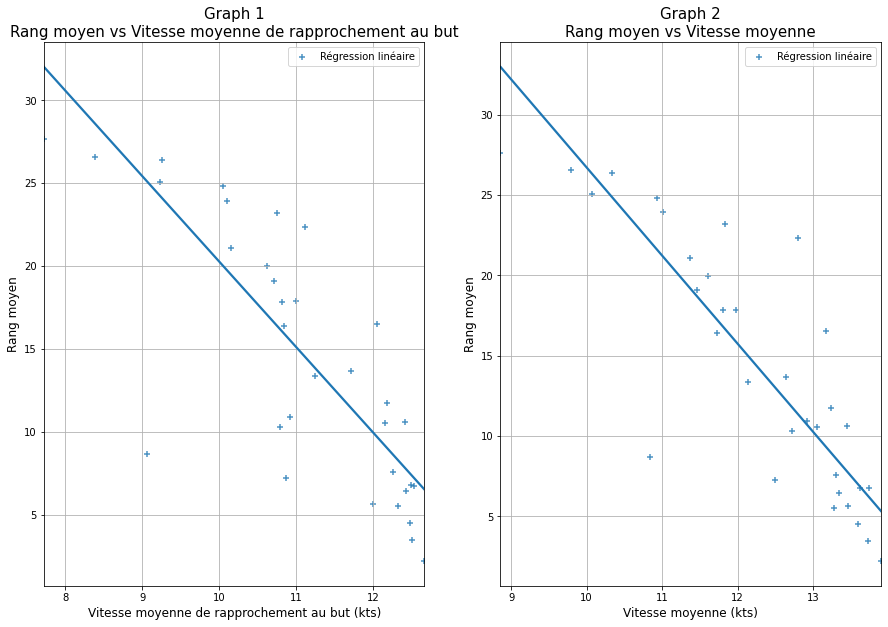

In [12]:
plt.figure(figsize=(15,10))

# Rang moyen vs Vitesse moyenne de rapprochement au but
plt.subplot(121)
sns.regplot(x=df4_1['VMG_24h (kts)'], y=df4_1['Rang'], marker = '+',order = 1, label = 'Régression linéaire', ci=None, robust = True)
plt.xlabel('Vitesse moyenne de rapprochement au but (kts)', fontsize=12)
plt.ylabel('Rang moyen', fontsize=12)
plt.legend()
plt.grid()
plt.title('Graph 1\nRang moyen vs Vitesse moyenne de rapprochement au but', fontsize=15)

# Rang moyen vs Vitesse moyenne
plt.subplot(122)
sns.regplot(x=df4_1['Vitesse_24h (kts)'], y=df4_1['Rang'], marker = '+',order = 1, label='Régression linéaire', ci=None, robust = True)
plt.xlabel('Vitesse moyenne (kts)', fontsize=12)
plt.ylabel('Rang moyen', fontsize=12)
plt.legend()
plt.grid()
plt.title('Graph 2\nRang moyen vs Vitesse moyenne', fontsize=15)

plt.show()

In [13]:
# Mathématiquement ...
X1 = np.array(df4_1['VMG_24h (kts)']).reshape(-1,1)
y = np.array(df4_1['Rang']).reshape(-1,1)
reg1 = LinearRegression().fit(X1,y)
print('Graph 1\n  coefficient de régression linéaire: %f\n  intercept: %f\n  coef de corrélation: %2.1f%%' % (reg1.coef_[0], 
                                                                                               reg1.intercept_,
                                                                                               m.sqrt(reg1.score(X1,y))*100))

X2 = np.array(df4_1['Vitesse_24h (kts)']).reshape(-1,1)
reg2 = LinearRegression().fit(X2,y)
print('Graph 2\n  coefficient de régression linéaire: %f\n  intercept: %f\n  coef de corrélation: %2.1f%%' % (reg2.coef_[0], 
                                                                                               reg2.intercept_,
                                                                                               m.sqrt(reg2.score(X2,y))*100))


Graph 1
  coefficient de régression linéaire: -4.716427
  intercept: 66.661550
  coef de corrélation: 78.9%
Graph 2
  coefficient de régression linéaire: -5.059051
  intercept: 76.343959
  coef de corrélation: 84.7%


Le graph 1 montre une forte corrélation (coef correlation = 78,9%) entre le rang moyen pendant la course et la vitesse moyenne de rapprochement au but des voiliers : comme on pouvait s'y attendre, le rang moyen est d'autant plus proche de 1 que la vitesse moyenne de rapprochement au but augmente.

Le graph 2 montre une corrélation encore plus forte (coef correlation = 84,7%) entre le rang moyen pendant la course et la vitesse moyenne des voiliers. Là encore, on constate que le rang moyen tend à décroitre à mesure que la vitesse moyenne augmente.

# **5. Impact de la présence d'un *foil* sur le classement et la vitesse des voiliers**

In [14]:
df5 = df_glob_ranking_extended[['Horodatage', 'Voile', 'Nombre de dérives', 'Vitesse_24h (kts)', 'Rang']]

# Suppression des lignes correspondant aux abandons
df5 = df5.replace('RET', np.nan).dropna()

# Les rapports sont publiés aux heures suivantes (en UTC) : 
# 4h (last+7h), 8h (last+4h), 11h (last+3h), 14h (last+3h), 17h (last+3h), 21h (last+4h)
# Le temps entre les rapports n'est pas constant, nous empêchant de calculer la vitesse moyenne 
# avec la moyenne des vitesses. Pour simplifier et pour pouvoir faire des moyennes de vitesses
# nous n'allons conserver arbitrairement chaque jour que les relevés de 14h
df5 = df5.loc[(df5['Horodatage'].dt.hour == 14) & (df5['Horodatage'].dt.minute == 0)]

# Création d'une colonne foils 
df5.loc[df5['Nombre de dérives'] == 'foils', 'foils'] = 'Yes'
df5.loc[df5['Nombre de dérives'] != 'foils', 'foils'] = 'No'
del df5['Nombre de dérives']

df5.loc[:, 'Rang'] = pd.to_numeric(df5['Rang'])
df5

,Horodatage,Voile,Vitesse_24h (kts),Rang,foils
0,2020-11-08 14:00:00,FRA 18,0.3,1,Yes
1,2020-11-08 14:00:00,MON 10,0.3,2,Yes
2,2020-11-08 14:00:00,FRA 08,0.2,3,Yes
3,2020-11-08 14:00:00,FRA 59,0.2,4,Yes
4,2020-11-08 14:00:00,FRA 53,0.8,5,No
...,...,...,...,...,...
15860,2021-01-27 14:00:00,FRA 71,12.9,21,No
15861,2021-01-27 14:00:00,FRA 50,10.5,22,No
15862,2021-01-27 14:00:00,FRA 83,9.6,23,No
15863,2021-01-27 14:00:00,FRA 72,11.4,24,No


In [15]:
df5_1=pd.pivot_table(df5, values=['Vitesse_24h (kts)', 'Rang'], index=['foils', 'Voile'], aggfunc='mean')
df5_1 = df5_1.reset_index()
df5_1

,foils,Voile,Rang,Vitesse_24h (kts)
0,No,ESP 33,19.975309,11.603704
1,No,FIN 222,26.370370,10.333333
2,No,FRA 01,5.506173,13.271605
3,No,FRA 04,10.925926,12.914815
4,No,FRA 09,7.567901,13.307407
5,No,FRA 1000,6.444444,13.338272
6,No,FRA 30,13.666667,12.643210
7,No,FRA 49,13.382716,12.138272
8,No,FRA 50,23.913580,11.004938
9,No,FRA 53,10.555556,13.055556


18 bateau possèdent un foil, 15 n'en possèdent pas

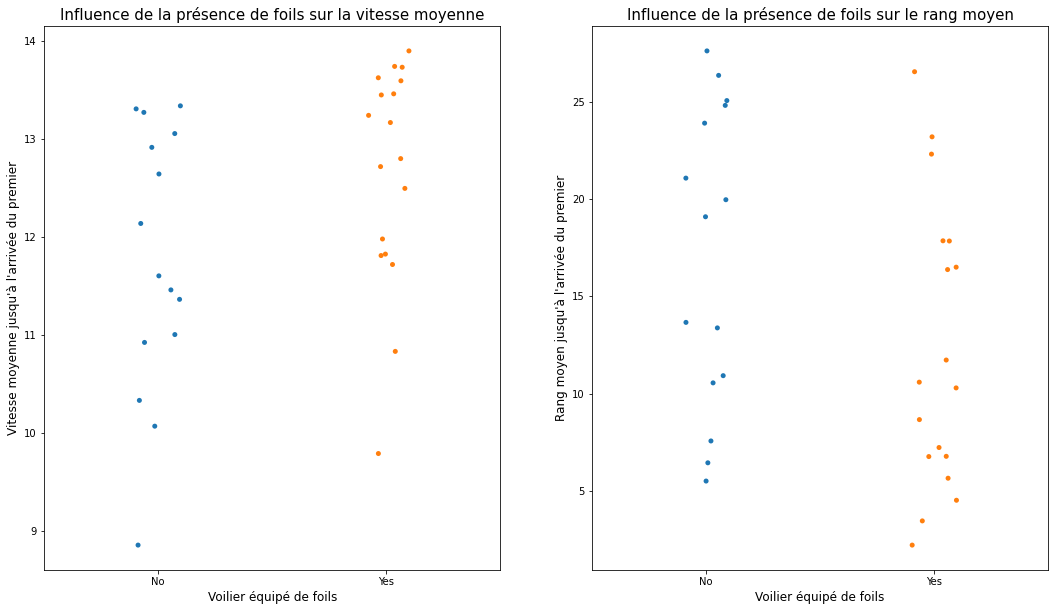

In [16]:
plt.figure(figsize=(18,10))

plt.subplot(121)
ax = sns.stripplot(data=df5_1, x='foils', y='Vitesse_24h (kts)');
ax.set_xlabel('Voilier équipé de foils', fontsize=12)
ax.set_ylabel('Vitesse moyenne jusqu\'à l\'arrivée du premier', fontsize=12)
ax.set_title('Influence de la présence de foils sur la vitesse moyenne', fontsize=15);

plt.subplot(122)
ax = sns.stripplot(data=df5_1, x='foils', y='Rang');
ax.set_xlabel('Voilier équipé de foils', fontsize=12)
ax.set_ylabel('Rang moyen jusqu\'à l\'arrivée du premier', fontsize=12)
ax.set_title('Influence de la présence de foils sur le rang moyen', fontsize=15);

plt.show()

D'après la visualisation graphique ci-dessus, les voiliers avec foils semblent avoir un avantage concurrentiel par rapport à ceux qui n'en ont pas. En particulier, on visualise bien qu'ils ont une vitesse moyenne qui tend à être plus élevée que les voiliers sans foils

In [17]:
df5_1.groupby('foils').mean()

,Rang,Vitesse_24h (kts)
foils,,
No,17.068242,11.752534
Yes,12.144034,12.660306


Ceci est confirmé par les statistiques calculées ci-dessus :

- Les voiliers possédant des foils sont en moyenne classés vers le 12ème rang et ont une vitesse moyenne de 12,66 kts.

- Les voiliers ne possédant pas de foils sont en moyenne classés vers le 17ème rang et ont une vitesse moyenne de 11,75 kts.

# **6. Visualisation de la distance parcourue par voilier**

In [18]:
df6 = df_glob_ranking_extended[['Voile', 'Horodatage', 'Distance_last (nm)']]

# Suppression des lignes sans Distance_last (nm)
df6 = df6.dropna()

df6 = df6.groupby(['Voile', 'Horodatage']).agg({'Distance_last (nm)':'sum'})
df6

Distance_last (nm)
Voile  Horodatage                             
ESP 33 2020-11-08 14:00:00              2789.1
       2020-11-08 17:00:00                24.1
       2020-11-08 21:00:00                52.8
       2020-11-09 04:00:00                66.9
       2020-11-09 08:00:00                32.1
...                                        ...
SUI 07 2021-01-26 21:00:00                50.8
       2021-01-27 04:00:00                97.7
       2021-01-27 08:00:00                61.9
       2021-01-27 11:00:00                44.5
       2021-01-27 14:00:00                44.2

[13671 rows x 1 columns]

In [19]:
# Detection des distances nautiques irréalistes entre 2 pointages pour suppression
# (toutes datées du 2020-11-08, soit le jour du départ)
df6.loc[df6['Distance_last (nm)']>1000]

,,Distance_last (nm)
Voile,Horodatage,
ESP 33,2020-11-08 14:00:00,2789.1
FIN 222,2020-11-08 14:00:00,2789.1
FRA 01,2020-11-08 14:00:00,2788.4
FRA 02,2020-11-08 14:00:00,2788.9
FRA 04,2020-11-08 14:00:00,2789.3
FRA 06,2020-11-08 14:00:00,2789.3
FRA 08,2020-11-08 14:00:00,2788.5
FRA 09,2020-11-08 14:00:00,2789.0
FRA 1000,2020-11-08 14:00:00,2788.4


In [20]:
df6 = df6.loc[df6['Distance_last (nm)']<1000]
df6

Distance_last (nm)
Voile  Horodatage                             
ESP 33 2020-11-08 17:00:00                24.1
       2020-11-08 21:00:00                52.8
       2020-11-09 04:00:00                66.9
       2020-11-09 08:00:00                32.1
       2020-11-09 11:00:00                24.4
...                                        ...
SUI 07 2021-01-26 21:00:00                50.8
       2021-01-27 04:00:00                97.7
       2021-01-27 08:00:00                61.9
       2021-01-27 11:00:00                44.5
       2021-01-27 14:00:00                44.2

[13639 rows x 1 columns]

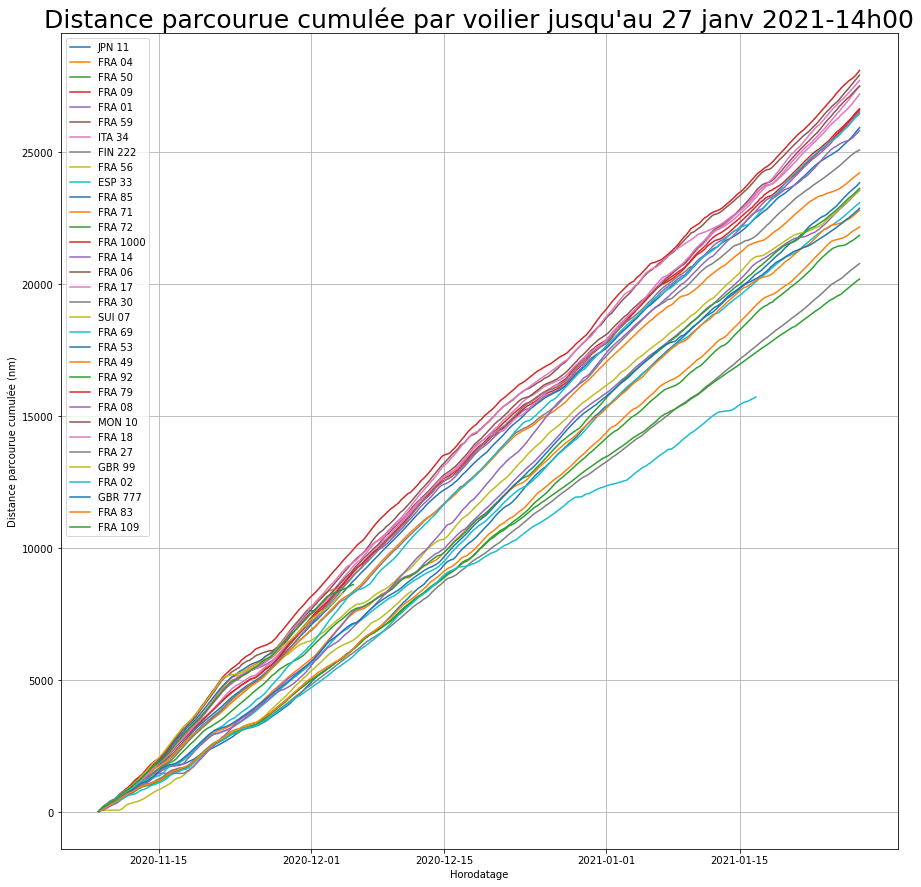

In [21]:
# représentation graphique
plt.figure(figsize=(15,15))
for boat in set(df_glob_ranking_extended['Voile']):
    plt.plot(df6.loc[boat].index, df6.loc[boat].cumsum(), label = boat)
plt.xlabel('Horodatage')
plt.ylabel('Distance parcourue cumulée (nm)')
plt.legend()
plt.title('Distance parcourue cumulée par voilier jusqu\'au 27 janv 2021-14h00', size = 25)
plt.grid()
plt.show()

# **7. Cartes avec les routes d'un ou plusieurs voiliers**

# **8. Analyses de séries temporelles.**

# **9. Application d'algorithmes statistiques ou de machine learning**